# 学習セッション

In [5]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from src.my_app import UNet, PreTrainDataset, create_optimized_dataloader
import torch
from PIL import Image
import torchvision.transforms as transforms
import os

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
import json
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing as mp


def crop_labels_to_match(labels_to_crop, target_tensor):
    target_h, target_w = target_tensor.shape[2:]
    source_h, source_w = labels_to_crop.shape[2:]
    delta_h = (source_h - target_h) // 2
    delta_w = (source_w - target_w) // 2
    return labels_to_crop[:, :, delta_h:delta_h + target_h, delta_w:delta_w + target_w]
transform = transforms.Compose([
    # transforms.Resizeze((128, 128)),
    transforms.ToTensor()
])
# --- Dataset ---
test_doc_id_list = ['100241706', '100249371', '100249376', '100249416', '100249476', '100249537', '200003076', '200003803', '200003967', '200004107']
train_dataset = PreTrainDataset(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=False,
    device=torch.device('cuda'),  # GPUを明示的に指定
    precompute_gt=False,  # 事前計算を有効化
    # num_workers=None
    transform=transform,  # 画像変換を追加
    target_width=300
)
test_dataset = PreTrainDataset(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=True,
    device=torch.device('cuda'),  # GPUを明示的に指定
    precompute_gt=False,  # 事前計算を有効化
    # num_workers=4
    transform=transform,  # 画像変換を追加
    target_width=300
)

# 最適化されたDataLoaderの作成
train_dl = create_optimized_dataloader(train_dataset, batch_size=1, num_workers=min(mp.cpu_count(), 4))
test_dl = create_optimized_dataloader(test_dataset, batch_size=1, num_workers=min(mp.cpu_count(), 4))

# --- モデル、損失関数、最適化手法の定義 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = UNet(3, 4).to(device)
criterion = nn.MSELoss() # 回帰問題なのでMSE損失を使用
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- チェックポイントの設定 ---
checkpoint_dir = "../.checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# 最良のモデルを追跡するための変数
best_test_loss = float('inf')
start_epoch = 0

# チェックポイントの読み込み（存在する場合）
checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_test_loss = checkpoint['best_test_loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    print(f"チェックポイントを読み込みました（エポック {start_epoch}）")

print("学習を開始します...")
num_epochs = 100 # エポック数を定義

# 損失の履歴を保存するリストを初期化
train_loss_history = []
test_loss_history = []

print("学習を開始します...")
for epoch in range(start_epoch, num_epochs):
    print(f'start epcoch')
    # --- 訓練フェーズ ---
    model.train() # モデルを訓練モードに設定
    train_loss_total = 0
    
    # tqdmでプログレスバーを表示
    train_bar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for imgs, masks in train_bar:
        imgs, masks = imgs.to(device), masks.to(device)
        
        preds = model(imgs)
        cropped_masks = crop_labels_to_match(masks, preds)

        loss = criterion(preds, cropped_masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_total += loss.item()
        # プログレスバーに現在のロスを表示
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = train_loss_total / len(train_dl)
    train_loss_history.append(avg_train_loss)

    # --- 評価フェーズ ---
    model.eval() # モデルを評価モードに設定
    test_loss_total = 0
    
    # 勾配計算を無効化して、メモリ効率を良くする
    with torch.no_grad():
        test_bar = tqdm(test_dl, desc=f"Epoch {epoch+1}/{num_epochs} [Test]")
        for imgs, masks in test_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            cropped_masks = crop_labels_to_match(masks, preds)
            
            loss = criterion(preds, cropped_masks)
            test_loss_total += loss.item()
            test_bar.set_postfix(loss=loss.item())

    avg_test_loss = test_loss_total / len(test_dl)
    test_loss_history.append(avg_test_loss)
    
    # 各エポックの最後に訓練ロスとテストロスを表示
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")
    
    # 最新のチェックポイントを保存
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss_history': train_loss_history,
        'test_loss_history': test_loss_history,
        'best_test_loss': best_test_loss
    }, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))
    
    # より良い性能が出た場合、ベストモデルとして保存
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': avg_test_loss,
        }, os.path.join(checkpoint_dir, "best_model.pth"))
        print(f"新しいベストモデルを保存しました（Test Loss: {avg_test_loss:.4f}）")

print("学習が完了しました。")

# --- 損失の推移をグラフで表示 ---
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.title("Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

Using device: cuda
jsonデータを読み込みました。
Using device: cuda
jsonデータを読み込みました。
Using device: cuda
jsonデータを読み込みました。
Using device: cuda
学習を開始します...
学習を開始します...
start epcoch
jsonデータを読み込みました。
Using device: cuda
学習を開始します...
学習を開始します...
start epcoch


Epoch 1/100 [Test]: 100%|██████████| 1143/1143 [19:45<00:00,  1.04s/it, loss=46.6]  



Epoch 1/100 | Train Loss: 97.4153 | Test Loss: 84.2593
新しいベストモデルを保存しました（Test Loss: 84.2593）
start epcoch
新しいベストモデルを保存しました（Test Loss: 84.2593）
start epcoch


Epoch 2/100 [Test]: 100%|██████████| 1143/1143 [19:23<00:00,  1.02s/it, loss=23.5]  



Epoch 2/100 | Train Loss: 85.6729 | Test Loss: 90.1358
start epcoch
start epcoch


Epoch 3/100 [Test]: 100%|██████████| 1143/1143 [19:28<00:00,  1.02s/it, loss=448]  



Epoch 3/100 | Train Loss: 85.0975 | Test Loss: 84.6215
start epcoch
start epcoch


Epoch 4/100 [Test]: 100%|██████████| 1143/1143 [19:05<00:00,  1.00s/it, loss=80.3]  



Epoch 4/100 | Train Loss: 119.2925 | Test Loss: 85.0798
start epcoch


Epoch 5/100 [Test]: 100%|██████████| 1143/1143 [19:12<00:00,  1.01s/it, loss=43.7]  



Epoch 5/100 | Train Loss: 84.4614 | Test Loss: 84.5060
start epcoch
start epcoch


Epoch 6/100 [Test]: 100%|██████████| 1143/1143 [19:17<00:00,  1.01s/it, loss=35.6]  



Epoch 6/100 | Train Loss: 84.6738 | Test Loss: 84.6833
start epcoch
start epcoch


Epoch 7/100 [Test]: 100%|██████████| 1143/1143 [19:14<00:00,  1.01s/it, loss=56.8]   



Epoch 7/100 | Train Loss: 84.9247 | Test Loss: 86.5030
start epcoch
start epcoch


Epoch 8/100 [Test]: 100%|██████████| 1143/1143 [24:34<00:00,  1.29s/it, loss=39.6]   



Epoch 8/100 | Train Loss: 84.4760 | Test Loss: 84.5195
start epcoch
start epcoch


Epoch 9/100 [Test]: 100%|██████████| 1143/1143 [19:26<00:00,  1.02s/it, loss=31.1]  



Epoch 9/100 | Train Loss: 84.5259 | Test Loss: 84.5923
start epcoch
start epcoch


Epoch 10/100 [Test]: 100%|██████████| 1143/1143 [21:13<00:00,  1.11s/it, loss=47.9]  



Epoch 10/100 | Train Loss: 84.1592 | Test Loss: 91.3569
start epcoch
start epcoch


Epoch 11/100 [Test]: 100%|██████████| 1143/1143 [19:32<00:00,  1.03s/it, loss=149]   



Epoch 11/100 | Train Loss: 84.2609 | Test Loss: 84.3110
start epcoch
start epcoch


Epoch 12/100 [Test]: 100%|██████████| 1143/1143 [19:42<00:00,  1.03s/it, loss=642]  



Epoch 12/100 | Train Loss: 83.9380 | Test Loss: 85.1903
start epcoch
start epcoch


Epoch 13/100 [Test]: 100%|██████████| 1143/1143 [19:42<00:00,  1.03s/it, loss=131]   



Epoch 13/100 | Train Loss: 84.2099 | Test Loss: 83.9515
新しいベストモデルを保存しました（Test Loss: 83.9515）
start epcoch
新しいベストモデルを保存しました（Test Loss: 83.9515）
start epcoch


Epoch 14/100 [Test]: 100%|██████████| 1143/1143 [19:45<00:00,  1.04s/it, loss=369]   



Epoch 14/100 | Train Loss: 83.9803 | Test Loss: 84.3090
start epcoch
start epcoch


Epoch 15/100 [Test]: 100%|██████████| 1143/1143 [19:37<00:00,  1.03s/it, loss=15.1]  



Epoch 15/100 | Train Loss: 83.7288 | Test Loss: 83.6718
新しいベストモデルを保存しました（Test Loss: 83.6718）
start epcoch
新しいベストモデルを保存しました（Test Loss: 83.6718）
start epcoch


Epoch 16/100 [Test]: 100%|██████████| 1143/1143 [19:38<00:00,  1.03s/it, loss=24.2]



Epoch 16/100 | Train Loss: 83.7242 | Test Loss: 84.5888
start epcoch
start epcoch


Epoch 17/100 [Test]: 100%|██████████| 1143/1143 [19:57<00:00,  1.05s/it, loss=132]    



Epoch 17/100 | Train Loss: 83.7724 | Test Loss: 84.1686
start epcoch
start epcoch


Epoch 18/100 [Test]: 100%|██████████| 1143/1143 [19:43<00:00,  1.04s/it, loss=48.7]  



Epoch 18/100 | Train Loss: 83.5832 | Test Loss: 84.2424
start epcoch
start epcoch


Epoch 19/100 [Test]: 100%|██████████| 1143/1143 [19:48<00:00,  1.04s/it, loss=39.6]  



Epoch 19/100 | Train Loss: 83.5198 | Test Loss: 83.7401
start epcoch
start epcoch


Epoch 20/100 [Test]: 100%|██████████| 1143/1143 [19:45<00:00,  1.04s/it, loss=120]   



Epoch 20/100 | Train Loss: 83.3993 | Test Loss: 85.9367
start epcoch
start epcoch


Epoch 21/100 [Test]: 100%|██████████| 1143/1143 [19:50<00:00,  1.04s/it, loss=60.6]  



Epoch 21/100 | Train Loss: 83.5331 | Test Loss: 84.0366
start epcoch
start epcoch


Epoch 22/100 [Test]: 100%|██████████| 1143/1143 [19:45<00:00,  1.04s/it, loss=34.9]   



Epoch 22/100 | Train Loss: 83.3359 | Test Loss: 85.9182
start epcoch
start epcoch


Epoch 23/100 [Test]: 100%|██████████| 1143/1143 [19:48<00:00,  1.04s/it, loss=461]  



Epoch 23/100 | Train Loss: 83.6576 | Test Loss: 84.2810
start epcoch
start epcoch


Epoch 24/100 [Test]: 100%|██████████| 1143/1143 [19:36<00:00,  1.03s/it, loss=99.9] 



Epoch 24/100 | Train Loss: 83.8436 | Test Loss: 85.0648
start epcoch
start epcoch


Epoch 25/100 [Test]: 100%|██████████| 1143/1143 [23:30<00:00,  1.23s/it, loss=55.8]  



Epoch 25/100 | Train Loss: 83.4648 | Test Loss: 83.6927
start epcoch
start epcoch


Epoch 26/100 [Test]: 100%|██████████| 1143/1143 [21:16<00:00,  1.12s/it, loss=62]   



Epoch 26/100 | Train Loss: 83.4315 | Test Loss: 84.1976
start epcoch
start epcoch


Epoch 27/100 [Test]: 100%|██████████| 1143/1143 [23:05<00:00,  1.21s/it, loss=69.6] 



Epoch 27/100 | Train Loss: 83.3414 | Test Loss: 84.0090
start epcoch
start epcoch


Epoch 28/100 [Test]: 100%|██████████| 1143/1143 [22:49<00:00,  1.20s/it, loss=37.4] 



Epoch 28/100 | Train Loss: 83.3681 | Test Loss: 83.1653
新しいベストモデルを保存しました（Test Loss: 83.1653）
start epcoch
新しいベストモデルを保存しました（Test Loss: 83.1653）
start epcoch


Epoch 29/100 [Test]: 100%|██████████| 1143/1143 [20:05<00:00,  1.05s/it, loss=70.2]  



Epoch 29/100 | Train Loss: 83.0598 | Test Loss: 83.6338
start epcoch
start epcoch


Epoch 30/100 [Test]: 100%|██████████| 1143/1143 [19:41<00:00,  1.03s/it, loss=31.5]  



Epoch 30/100 | Train Loss: 83.3240 | Test Loss: 83.2051
start epcoch
start epcoch


Epoch 31/100 [Test]: 100%|██████████| 1143/1143 [19:28<00:00,  1.02s/it, loss=31.4]   



Epoch 31/100 | Train Loss: 83.0328 | Test Loss: 83.5362
start epcoch
start epcoch


Epoch 32/100 [Test]: 100%|██████████| 1143/1143 [19:41<00:00,  1.03s/it, loss=20.3]  



Epoch 32/100 | Train Loss: 83.1319 | Test Loss: 83.2800
start epcoch
start epcoch


Epoch 33/100 [Test]: 100%|██████████| 1143/1143 [19:25<00:00,  1.02s/it, loss=18.8]  



Epoch 33/100 | Train Loss: 82.9641 | Test Loss: 83.7826
start epcoch
start epcoch


Epoch 34/100 [Test]: 100%|██████████| 1143/1143 [19:42<00:00,  1.03s/it, loss=18]  



Epoch 34/100 | Train Loss: 82.9010 | Test Loss: 101.7641
start epcoch
start epcoch


Epoch 35/100 [Test]: 100%|██████████| 1143/1143 [19:30<00:00,  1.02s/it, loss=114]   



Epoch 35/100 | Train Loss: 83.1067 | Test Loss: 85.2193
start epcoch
start epcoch


Epoch 36/100 [Test]: 100%|██████████| 1143/1143 [19:29<00:00,  1.02s/it, loss=133]   



Epoch 36/100 | Train Loss: 82.9229 | Test Loss: 83.6263
start epcoch
start epcoch


Epoch 37/100 [Test]: 100%|██████████| 1143/1143 [19:33<00:00,  1.03s/it, loss=53.7]  



Epoch 37/100 | Train Loss: 83.2184 | Test Loss: 84.4060
start epcoch
start epcoch


Epoch 38/100 [Test]: 100%|██████████| 1143/1143 [22:19<00:00,  1.17s/it, loss=108]   



Epoch 38/100 | Train Loss: 82.7082 | Test Loss: 83.7611
start epcoch
start epcoch


Epoch 39/100 [Test]: 100%|██████████| 1143/1143 [19:27<00:00,  1.02s/it, loss=84.7]  



Epoch 39/100 | Train Loss: 82.6489 | Test Loss: 84.3586
start epcoch
start epcoch


Epoch 40/100 [Test]: 100%|██████████| 1143/1143 [19:23<00:00,  1.02s/it, loss=60]    



Epoch 40/100 | Train Loss: 82.9251 | Test Loss: 83.3089
start epcoch
start epcoch


Epoch 41/100 [Test]: 100%|██████████| 1143/1143 [19:19<00:00,  1.01s/it, loss=31.2]  



Epoch 41/100 | Train Loss: 82.9677 | Test Loss: 84.9559
start epcoch
start epcoch


Epoch 42/100 [Test]: 100%|██████████| 1143/1143 [19:29<00:00,  1.02s/it, loss=49.2]  



Epoch 42/100 | Train Loss: 82.5880 | Test Loss: 83.1096
新しいベストモデルを保存しました（Test Loss: 83.1096）
start epcoch
新しいベストモデルを保存しました（Test Loss: 83.1096）
start epcoch


Epoch 43/100 [Test]: 100%|██████████| 1143/1143 [19:19<00:00,  1.01s/it, loss=22.1] 



Epoch 43/100 | Train Loss: 82.7249 | Test Loss: 83.2629
start epcoch
start epcoch


Epoch 44/100 [Test]: 100%|██████████| 1143/1143 [19:21<00:00,  1.02s/it, loss=21.1]   



Epoch 44/100 | Train Loss: 82.5228 | Test Loss: 86.8036
start epcoch
start epcoch


Epoch 45/100 [Test]: 100%|██████████| 1143/1143 [19:32<00:00,  1.03s/it, loss=72.8]  



Epoch 45/100 | Train Loss: 82.6260 | Test Loss: 83.3078
start epcoch
start epcoch


Epoch 46/100 [Test]: 100%|██████████| 1143/1143 [19:32<00:00,  1.03s/it, loss=243]   



Epoch 46/100 | Train Loss: 82.4888 | Test Loss: 83.4720
start epcoch
start epcoch


Epoch 47/100 [Test]: 100%|██████████| 1143/1143 [24:26<00:00,  1.28s/it, loss=155] 



Epoch 47/100 | Train Loss: 82.4751 | Test Loss: 93.9331
start epcoch
start epcoch


Epoch 48/100 [Test]: 100%|██████████| 1143/1143 [19:23<00:00,  1.02s/it, loss=72.7]  



Epoch 48/100 | Train Loss: 82.4905 | Test Loss: 85.1908
start epcoch
start epcoch


Epoch 49/100 [Test]: 100%|██████████| 1143/1143 [19:27<00:00,  1.02s/it, loss=68.5]  



Epoch 49/100 | Train Loss: 82.5343 | Test Loss: 83.6518
start epcoch
start epcoch


Epoch 50/100 [Test]: 100%|██████████| 1143/1143 [19:25<00:00,  1.02s/it, loss=220]  



Epoch 50/100 | Train Loss: 82.5904 | Test Loss: 83.6716
start epcoch
start epcoch


Epoch 51/100 [Test]: 100%|██████████| 1143/1143 [19:38<00:00,  1.03s/it, loss=38.1]  



Epoch 51/100 | Train Loss: 82.3495 | Test Loss: 83.6061
start epcoch
start epcoch


Epoch 52/100 [Test]: 100%|██████████| 1143/1143 [19:35<00:00,  1.03s/it, loss=94.4]  



Epoch 52/100 | Train Loss: 82.4827 | Test Loss: 83.3022
start epcoch
start epcoch


Epoch 53/100 [Test]: 100%|██████████| 1143/1143 [19:40<00:00,  1.03s/it, loss=50.1]  



Epoch 53/100 | Train Loss: 82.3858 | Test Loss: 83.4645
start epcoch
start epcoch


Epoch 54/100 [Test]: 100%|██████████| 1143/1143 [19:33<00:00,  1.03s/it, loss=65.7]  



Epoch 54/100 | Train Loss: 82.2912 | Test Loss: 88.0853
start epcoch
start epcoch


Epoch 55/100 [Test]: 100%|██████████| 1143/1143 [19:29<00:00,  1.02s/it, loss=97.9]   



Epoch 55/100 | Train Loss: 82.3187 | Test Loss: 83.5276
start epcoch
start epcoch


Epoch 56/100 [Test]: 100%|██████████| 1143/1143 [19:29<00:00,  1.02s/it, loss=71.6]  



Epoch 56/100 | Train Loss: 82.4233 | Test Loss: 82.9773
新しいベストモデルを保存しました（Test Loss: 82.9773）
start epcoch
新しいベストモデルを保存しました（Test Loss: 82.9773）
start epcoch


Epoch 57/100 [Test]: 100%|██████████| 1143/1143 [19:33<00:00,  1.03s/it, loss=38.9]  



Epoch 57/100 | Train Loss: 82.4359 | Test Loss: 83.4951
start epcoch
start epcoch


Epoch 58/100 [Test]: 100%|██████████| 1143/1143 [19:31<00:00,  1.02s/it, loss=355]   



Epoch 58/100 | Train Loss: 82.3757 | Test Loss: 84.2980
start epcoch
start epcoch


Epoch 59/100 [Test]: 100%|██████████| 1143/1143 [19:50<00:00,  1.04s/it, loss=122]   



Epoch 59/100 | Train Loss: 82.5173 | Test Loss: 84.4214
start epcoch
start epcoch


Epoch 60/100 [Test]: 100%|██████████| 1143/1143 [19:27<00:00,  1.02s/it, loss=33.4]  



Epoch 60/100 | Train Loss: 82.4311 | Test Loss: 84.2581
start epcoch
start epcoch


Epoch 61/100 [Test]: 100%|██████████| 1143/1143 [19:30<00:00,  1.02s/it, loss=33]    



Epoch 61/100 | Train Loss: 82.2664 | Test Loss: 83.5592
start epcoch
start epcoch


Epoch 62/100 [Test]: 100%|██████████| 1143/1143 [19:32<00:00,  1.03s/it, loss=66.9]  



Epoch 62/100 | Train Loss: 82.2904 | Test Loss: 84.3045
start epcoch
start epcoch


Epoch 63/100 [Test]: 100%|██████████| 1143/1143 [19:16<00:00,  1.01s/it, loss=65.9]  



Epoch 63/100 | Train Loss: 82.1814 | Test Loss: 83.5152
start epcoch
start epcoch


Epoch 64/100 [Test]: 100%|██████████| 1143/1143 [19:23<00:00,  1.02s/it, loss=4.59]  



Epoch 64/100 | Train Loss: 82.2062 | Test Loss: 83.2726
start epcoch
start epcoch


Epoch 65/100 [Test]: 100%|██████████| 1143/1143 [19:26<00:00,  1.02s/it, loss=369]  



Epoch 65/100 | Train Loss: 82.1870 | Test Loss: 83.4233
start epcoch
start epcoch


Epoch 66/100 [Test]: 100%|██████████| 1143/1143 [19:45<00:00,  1.04s/it, loss=146]   



Epoch 66/100 | Train Loss: 82.2483 | Test Loss: 83.2275
start epcoch
start epcoch


Epoch 67/100 [Test]: 100%|██████████| 1143/1143 [19:37<00:00,  1.03s/it, loss=24.3]  



Epoch 67/100 | Train Loss: 82.4646 | Test Loss: 85.8806
start epcoch
start epcoch


Epoch 68/100 [Test]: 100%|██████████| 1143/1143 [19:24<00:00,  1.02s/it, loss=41.2]  



Epoch 68/100 | Train Loss: 82.9949 | Test Loss: 83.3894
start epcoch
start epcoch


Epoch 69/100 [Test]: 100%|██████████| 1143/1143 [19:38<00:00,  1.03s/it, loss=14.1]  



Epoch 69/100 | Train Loss: 82.1790 | Test Loss: 83.5073
start epcoch
start epcoch


Epoch 70/100 [Test]: 100%|██████████| 1143/1143 [19:22<00:00,  1.02s/it, loss=36.5] 



Epoch 70/100 | Train Loss: 82.2429 | Test Loss: 85.4536
start epcoch
start epcoch


Epoch 71/100 [Test]: 100%|██████████| 1143/1143 [19:21<00:00,  1.02s/it, loss=33]  



Epoch 71/100 | Train Loss: 82.1993 | Test Loss: 84.1098
start epcoch
start epcoch


Epoch 72/100 [Test]: 100%|██████████| 1143/1143 [19:46<00:00,  1.04s/it, loss=65.7]   



Epoch 72/100 | Train Loss: 82.0694 | Test Loss: 84.1232
start epcoch
start epcoch


Epoch 73/100 [Test]: 100%|██████████| 1143/1143 [19:34<00:00,  1.03s/it, loss=53.7]  



Epoch 73/100 | Train Loss: 82.1740 | Test Loss: 83.0280
start epcoch
start epcoch


Epoch 74/100 [Test]: 100%|██████████| 1143/1143 [19:19<00:00,  1.01s/it, loss=49.9]  



Epoch 74/100 | Train Loss: 82.0203 | Test Loss: 84.9408
start epcoch
start epcoch


Epoch 75/100 [Test]: 100%|██████████| 1143/1143 [19:23<00:00,  1.02s/it, loss=15.5]  



Epoch 75/100 | Train Loss: 82.0657 | Test Loss: 83.7919
start epcoch
start epcoch


Epoch 76/100 [Test]: 100%|██████████| 1143/1143 [19:35<00:00,  1.03s/it, loss=88.6]  



Epoch 76/100 | Train Loss: 82.1731 | Test Loss: 83.3959
start epcoch
start epcoch


Epoch 77/100 [Test]: 100%|██████████| 1143/1143 [19:34<00:00,  1.03s/it, loss=51]   



Epoch 77/100 | Train Loss: 81.9169 | Test Loss: 83.1204
start epcoch
start epcoch


Epoch 78/100 [Test]: 100%|██████████| 1143/1143 [19:35<00:00,  1.03s/it, loss=7.07]  



Epoch 78/100 | Train Loss: 82.0143 | Test Loss: 83.9247
start epcoch
start epcoch


Epoch 79/100 [Test]: 100%|██████████| 1143/1143 [19:41<00:00,  1.03s/it, loss=7.67]



Epoch 79/100 | Train Loss: 82.1406 | Test Loss: 83.7060
start epcoch
start epcoch


Epoch 80/100 [Test]: 100%|██████████| 1143/1143 [19:45<00:00,  1.04s/it, loss=43.4]  



Epoch 80/100 | Train Loss: 82.2753 | Test Loss: 83.6002
start epcoch
start epcoch


Epoch 81/100 [Test]: 100%|██████████| 1143/1143 [19:32<00:00,  1.03s/it, loss=42.1]  



Epoch 81/100 | Train Loss: 81.9340 | Test Loss: 83.5758
start epcoch
start epcoch


Epoch 82/100 [Test]: 100%|██████████| 1143/1143 [19:25<00:00,  1.02s/it, loss=66.6]   



Epoch 82/100 | Train Loss: 81.9526 | Test Loss: 83.6933
start epcoch
start epcoch


Epoch 83/100 [Test]: 100%|██████████| 1143/1143 [19:25<00:00,  1.02s/it, loss=35.4] 



Epoch 83/100 | Train Loss: 82.0030 | Test Loss: 83.6426
start epcoch
start epcoch


Epoch 84/100 [Test]: 100%|██████████| 1143/1143 [19:31<00:00,  1.02s/it, loss=33.4]  



Epoch 84/100 | Train Loss: 81.7908 | Test Loss: 83.2062
start epcoch
start epcoch


Epoch 85/100 [Test]: 100%|██████████| 1143/1143 [19:31<00:00,  1.02s/it, loss=66.8] 



Epoch 85/100 | Train Loss: 81.9734 | Test Loss: 83.2375
start epcoch
start epcoch


Epoch 86/100 [Test]: 100%|██████████| 1143/1143 [19:25<00:00,  1.02s/it, loss=9.8]   



Epoch 86/100 | Train Loss: 81.9202 | Test Loss: 83.5036
start epcoch
start epcoch


Epoch 87/100 [Test]: 100%|██████████| 1143/1143 [19:40<00:00,  1.03s/it, loss=106]    



Epoch 87/100 | Train Loss: 81.7366 | Test Loss: 83.7262
start epcoch
start epcoch


Epoch 88/100 [Test]: 100%|██████████| 1143/1143 [20:21<00:00,  1.07s/it, loss=112]   



Epoch 88/100 | Train Loss: 82.2718 | Test Loss: 83.5361
start epcoch
start epcoch


Epoch 89/100 [Test]: 100%|██████████| 1143/1143 [19:13<00:00,  1.01s/it, loss=252]  



Epoch 89/100 | Train Loss: 81.7635 | Test Loss: 85.3177
start epcoch
start epcoch


Epoch 90/100 [Test]: 100%|██████████| 1143/1143 [21:58<00:00,  1.15s/it, loss=583]    



Epoch 90/100 | Train Loss: 81.8726 | Test Loss: 83.2738
start epcoch
start epcoch


Epoch 91/100 [Test]: 100%|██████████| 1143/1143 [19:57<00:00,  1.05s/it, loss=43.9]  


Epoch 91/100 | Train Loss: 81.9403 | Test Loss: 83.3746
start epcoch


Epoch 92/100 [Test]: 100%|██████████| 1143/1143 [19:52<00:00,  1.04s/it, loss=165]   


Epoch 92/100 | Train Loss: 81.7504 | Test Loss: 84.9499
start epcoch


Epoch 93/100 [Test]: 100%|██████████| 1143/1143 [19:33<00:00,  1.03s/it, loss=50.4]  


Epoch 93/100 | Train Loss: 81.7472 | Test Loss: 85.0783
start epcoch


Epoch 94/100 [Test]: 100%|██████████| 1143/1143 [19:36<00:00,  1.03s/it, loss=102]   


Epoch 94/100 | Train Loss: 81.8311 | Test Loss: 83.9692
start epcoch


Epoch 95/100 [Test]: 100%|██████████| 1143/1143 [19:31<00:00,  1.03s/it, loss=45.5] 


Epoch 95/100 | Train Loss: 81.8854 | Test Loss: 83.1948
start epcoch


Epoch 96/100 [Test]: 100%|██████████| 1143/1143 [19:31<00:00,  1.03s/it, loss=19.5] 


Epoch 96/100 | Train Loss: 81.8267 | Test Loss: 83.2953
start epcoch


Epoch 97/100 [Test]: 100%|██████████| 1143/1143 [24:30<00:00,  1.29s/it, loss=37.9]   


Epoch 97/100 | Train Loss: 81.8091 | Test Loss: 84.4607
start epcoch


Epoch 98/100 [Test]: 100%|██████████| 1143/1143 [19:54<00:00,  1.05s/it, loss=40.8]  


Epoch 98/100 | Train Loss: 81.8949 | Test Loss: 87.2300
start epcoch


Epoch 99/100 [Train]:  39%|███▉      | 1930/4965 [35:04<1:02:44,  1.24s/it, loss=35.7]   

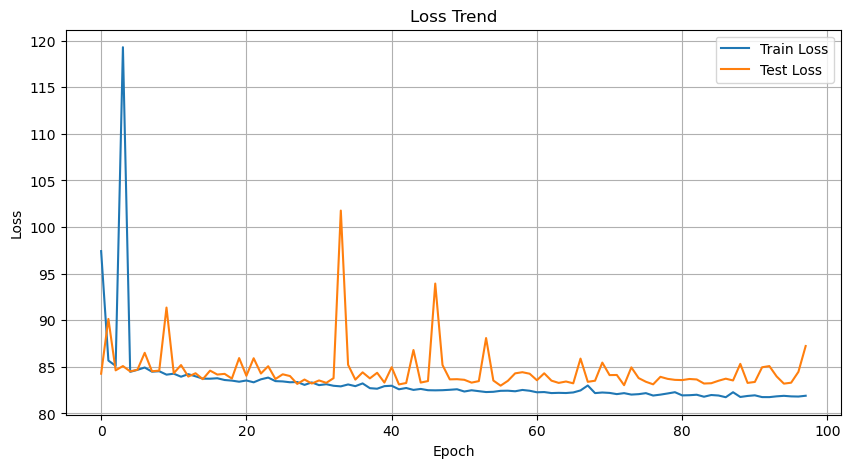

In [10]:
train_loss_history = [
    97.4153, 85.6729, 85.0975, 119.2925, 84.4614, 84.6738, 84.9247, 84.4760,
    84.5259, 84.1592, 84.2609, 83.9380, 84.2099, 83.9803, 83.7288, 83.7242,
    83.7724, 83.5832, 83.5198, 83.3993, 83.5331, 83.3359, 83.6576, 83.8436,
    83.4648, 83.4315, 83.3414, 83.3681, 83.0598, 83.3240, 83.0328, 83.1319,
    82.9641, 82.9010, 83.1067, 82.9229, 83.2184, 82.7082, 82.6489, 82.9251,
    82.9677, 82.5880, 82.7249, 82.5228, 82.6260, 82.4888, 82.4751, 82.4905,
    82.5343, 82.5904, 82.3495, 82.4827, 82.3858, 82.2912, 82.3187, 82.4233,
    82.4359, 82.3757, 82.5173, 82.4311, 82.2664, 82.2904, 82.1814, 82.2062,
    82.1870, 82.2483, 82.4646, 82.9949, 82.1790, 82.2429, 82.1993, 82.0694,
    82.1740, 82.0203, 82.0657, 82.1731, 81.9169, 82.0143, 82.1406, 82.2753,
    81.9340, 81.9526, 82.0030, 81.7908, 81.9734, 81.9202, 81.7366, 82.2718,
    81.7635, 81.8726, 81.9403, 81.7504, 81.7472, 81.8311, 81.8854, 81.8267,
    81.8091, 81.8949
]

test_loss_history = [
    84.2593, 90.1358, 84.6215, 85.0798, 84.5060, 84.6833, 86.5030, 84.5195,
    84.5923, 91.3569, 84.3110, 85.1903, 83.9515, 84.3090, 83.6718, 84.5888,
    84.1686, 84.2424, 83.7401, 85.9367, 84.0366, 85.9182, 84.2810, 85.0648,
    83.6927, 84.1976, 84.0090, 83.1653, 83.6338, 83.2051, 83.5362, 83.2800,
    83.7826, 101.7641, 85.2193, 83.6263, 84.4060, 83.7611, 84.3586, 83.3089,
    84.9559, 83.1096, 83.2629, 86.8036, 83.3078, 83.4720, 93.9331, 85.1908,
    83.6518, 83.6716, 83.6061, 83.3022, 83.4645, 88.0853, 83.5276, 82.9773,
    83.4951, 84.2980, 84.4214, 84.2581, 83.5592, 84.3045, 83.5152, 83.2726,
    83.4233, 83.2275, 85.8806, 83.3894, 83.5073, 85.4536, 84.1098, 84.1232,
    83.0280, 84.9408, 83.7919, 83.3959, 83.1204, 83.9247, 83.7060, 83.6002,
    83.5758, 83.6933, 83.6426, 83.2062, 83.2375, 83.5036, 83.7262, 83.5361,
    85.3177, 83.2738, 83.3746, 84.9499, 85.0783, 83.9692, 83.1948, 83.2953,
    84.4607, 87.2300
]

# --- 損失の推移をグラフで表示 ---
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.title("Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 学習済みモデルの出力を確認

## チェックポイントのロード動作確認

In [ ]:
# --- チェックポイントの設定 ---.checkpoints/latest_checkpoint.pth
checkpoint_dir = '../.checkpoints'
checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pth")

# 現在のデバイス状況を確認
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")

if os.path.exists(checkpoint_path):
    # デバイス間の互換性を保つための読み込み
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    print(f"チェックポイントを読み込みました: {checkpoint_path}")
    print(f"エポック: {checkpoint.get('epoch', 'N/A')}")
    print(f"ベストテストロス: {checkpoint.get('best_test_loss', 'N/A')}")
    print(f"訓練ロス履歴の長さ: {len(checkpoint.get('train_loss_history', []))}")
    print(f"テストロス履歴の長さ: {len(checkpoint.get('test_loss_history', []))}")
else:
    print(f"チェックポイントが見つかりません: {checkpoint_path}")
    checkpoint = None
    checkpoint = None

In [9]:
# --- チェックポイントの設定 ---.checkpoints/latest_checkpoint.pth
checkpoint_dir = '../.checkpoints'
checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pth")

# 現在のデバイス状況を確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if os.path.exists(checkpoint_path):
    # デバイス間の互換性を保つための読み込み
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    print(f"チェックポイントを読み込みました: {checkpoint_path}")
    print(f"エポック: {checkpoint.get('epoch', 'N/A')}")
    print(f"ベストテストロス: {checkpoint.get('best_test_loss', 'N/A')}")
    print(f"訓練ロス履歴の長さ: {len(checkpoint.get('train_loss_history', []))}")
    print(f"テストロス履歴の長さ: {len(checkpoint.get('test_loss_history', []))}")
else:
    print(f"チェックポイントが見つかりません: {checkpoint_path}")
    checkpoint = None
    checkpoint = None

Using device: cuda
チェックポイントを読み込みました: ../.checkpoints\latest_checkpoint.pth
エポック: 100
ベストテストロス: 82.92743761760565
訓練ロス履歴の長さ: 100
テストロス履歴の長さ: 100


## 画像読み込みと torch tensor 変換

In [4]:
def load_image_as_tensor(image_path, device=None, target_size=None, normalize=True):
    """
    画像ファイルを読み込んでtorch.tensorに変換する
    
    Args:
        image_path (str): 画像ファイルのパス
        device (torch.device, optional): テンソルを配置するデバイス。Noneの場合は自動選択
        target_size (tuple, optional): リサイズするサイズ (height, width)
        normalize (bool): 正規化を行うかどうか (0-1の範囲に変換)
    
    Returns:
        torch.Tensor: 変換された画像テンソル (C, H, W)
    """
    
    # デバイスの自動選択
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    # ファイルの存在確認
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"画像ファイルが見つかりません: {image_path}")
    
    try:
        # 画像を読み込み
        image = Image.open(image_path)
        
        # RGBに変換（PNGのアルファチャンネルなどを除去）
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        # 変換パイプラインを構築
        transform_list = []
        
        # リサイズ
        if target_size is not None:
            transform_list.append(transforms.Resize(target_size))
        
        # テンソル変換
        transform_list.append(transforms.ToTensor())
        
        # 正規化（ToTensorで既に0-1に正規化されるが、ImageNetの標準化も可能）
        # 明るさを揃えてくれる。
        if normalize == 'imagenet':
            transform_list.append(transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ))
        
        # 変換を実行
        transform = transforms.Compose(transform_list)
        tensor = transform(image)
        
        # デバイスに移動
        tensor = tensor.to(device)
        
        return tensor
        
    except Exception as e:
        raise RuntimeError(f"画像の読み込み/変換でエラーが発生しました: {e}")


Using device: mps
チェックポイントを読み込みました（エポック 56）
画像の推測開始
torch.Size([1, 4, 480, 288])


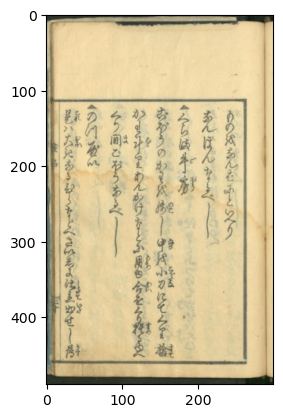

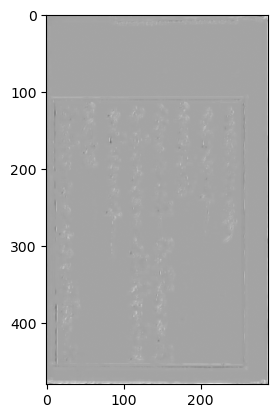

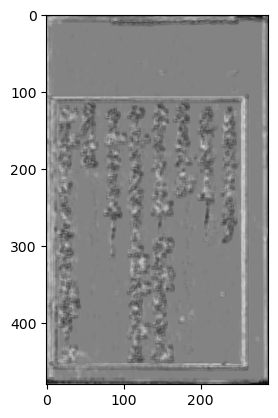

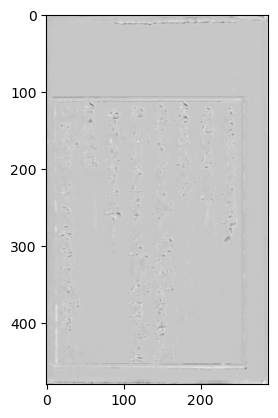

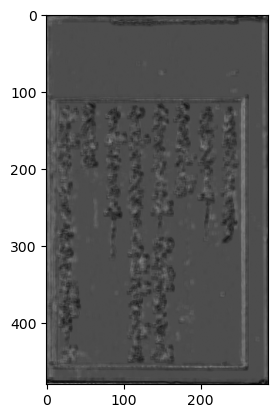

In [18]:
# --- チェックポイントの設定 ---.checkpoints/latest_checkpoint.pth
# 現在のデバイス状況を確認
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# image_path = "../.image_data/100241706_00002_2.jpg"
image_path = "../.image_data/100241706_00026_2.jpg"
checkpoint_file = 'best_model.pth'
# checkpoint_file = '"latest_checkpoint.pth"'
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Using device: {device}")
# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = UNet(3, 4).to(device)
criterion = nn.MSELoss() # 回帰問題なのでMSE損失を使用
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- チェックポイントの設定 ---
checkpoint_dir = "../.checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# 最良のモデルを追跡するための変数
best_test_loss = float('inf')
start_epoch = 0

# チェックポイントの読み込み（存在する場合）
# セル6のチェックポイント読み込み部分を修正
checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
if os.path.exists(checkpoint_path):
    # CUDAからMPS/CPUへの変換を明示的に行う
    if device.type == 'mps':
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('mps'))
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # OptimizerもCPU/MPSに適応させる必要がある場合がある
    try:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    except RuntimeError as e:
        print(f"Optimizer状態の読み込みに失敗: {e}")
        print("新しいOptimizerで続行します")
    
    start_epoch = checkpoint['epoch']
    # best_test_loss = checkpoint['best_test_loss']
    # train_loss_history = checkpoint['train_loss_history']
    # test_loss_history = checkpoint['test_loss_history']
    print(f"チェックポイントを読み込みました（エポック {start_epoch}）")



# 入力画像の読み込み
try:
    # 画像をテンソルに変換
    image_tensor = load_image_as_tensor(
        image_path=image_path,
        device=device,
        target_size=300,  # 必要に応じてリサイズ
        normalize=True
    )
except Exception as e:
    print(f"画像の読み込み/変換でエラーが発生しました: {e}")
    sys.exit(1)

print("画像の推測開始")
pred = model(image_tensor.unsqueeze(0))  # バッチ次元を追加
print(f'{pred.shape}')

plt.imshow(image_tensor.cpu().detach().numpy().transpose(1, 2, 0))  # テンソルをNumPy配列に変換して表示
plt.show(   )
for i in range(4):
    pred_i = pred[0, i].cpu().detach().numpy()  # GPUからCPUに移動してNumPy配列に変換
    # plt.subplot(1, 4, i + 1)
    plt.imshow(pred_i, cmap='gray')
    # plt.axis('off')
    plt.show()


# ロスが減少していない問題の原因を探る

## 学習データに異常があるのではないか

In [2]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from src.my_app import UNet, PreTrainDataset, create_optimized_dataloader
import torch
from PIL import Image
import torchvision.transforms as transforms
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
import json
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing as mp


def crop_labels_to_match(labels_to_crop, target_tensor):
    target_h, target_w = target_tensor.shape[2:]
    source_h, source_w = labels_to_crop.shape[2:]
    delta_h = (source_h - target_h) // 2
    delta_w = (source_w - target_w) // 2
    return labels_to_crop[:, :, delta_h:delta_h + target_h, delta_w:delta_w + target_w]
transform = transforms.Compose([
    # transforms.Resizeze((128, 128)),
    transforms.ToTensor()
])
# --- Dataset ---
test_doc_id_list = ['100241706', '100249371', '100249376', '100249416', '100249476', '100249537', '200003076', '200003803', '200003967', '200004107']
train_dataset = PreTrainDataset(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=False,
    device=torch.device('cuda'),  # GPUを明示的に指定
    precompute_gt=False,  # 事前計算を有効化
    # num_workers=None
    transform=transform,  # 画像変換を追加
    target_width=300
)
test_dataset = PreTrainDataset(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=True,
    device=torch.device('cuda'),  # GPUを明示的に指定
    precompute_gt=False,  # 事前計算を有効化
    # num_workers=4
    transform=transform,  # 画像変換を追加
    target_width=300
)

# 最適化されたDataLoaderの作成
train_dl = create_optimized_dataloader(train_dataset, batch_size=1, num_workers=min(mp.cpu_count(), 4))
test_dl = create_optimized_dataloader(test_dataset, batch_size=1, num_workers=min(mp.cpu_count(), 4))

Using device: cuda
jsonデータを読み込みました。
Using device: cuda
jsonデータを読み込みました。


## 正解データを出力してみる：壊れてた。。

In [ ]:

# --- モデル、損失関数、最適化手法の定義 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for epoch in range(1):
    # train_bar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{1} [Train]")
    print(f'{epoch=}')
    for imgs, masks in train_dl:
        print(f'{masks.shape}')
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.imshow(masks[0, i].cpu().detach().numpy())
        # plt.hist(imgs[0].cpu().detach().numpy().flatten(), bins=50)
        plt.show()

# 古いデータセット型で学習する。

json データを読み込みました。
json データを読み込みました。
Using device: cuda
学習を開始します...
start epcoch


Epoch 1/100 [Train]:   0%|          | 0/4965 [00:00<?, ?it/s]

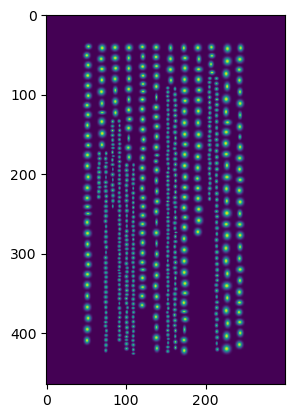

Epoch 1/100 [Train]:   0%|          | 1/4965 [00:42<58:35:04, 42.49s/it, loss=0.0225]

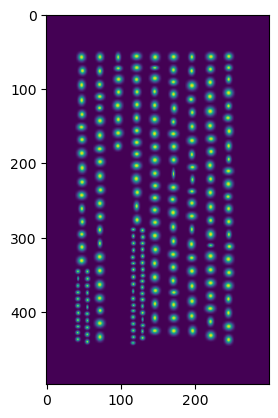

Epoch 1/100 [Train]:   0%|          | 2/4965 [00:43<25:06:15, 18.21s/it, loss=0.0185]

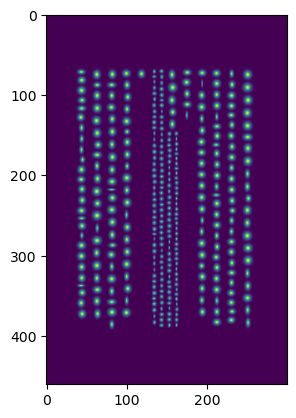

Epoch 1/100 [Train]:   0%|          | 3/4965 [00:43<13:42:30,  9.95s/it, loss=0.0117]

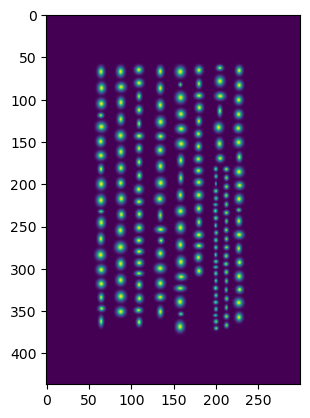

Epoch 1/100 [Train]:   0%|          | 4/4965 [00:43<8:21:35,  6.07s/it, loss=0.0103] 

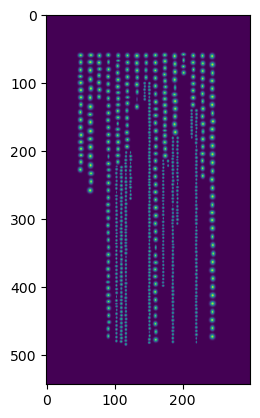

Epoch 1/100 [Train]:   0%|          | 5/4965 [00:44<5:24:08,  3.92s/it, loss=0.00822]

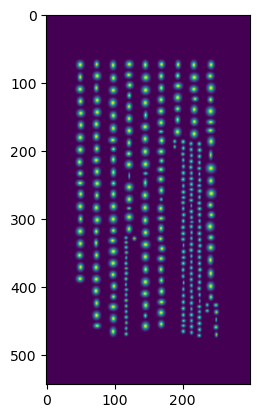

Epoch 1/100 [Train]:   0%|          | 6/4965 [00:44<3:37:34,  2.63s/it, loss=0.0133] 

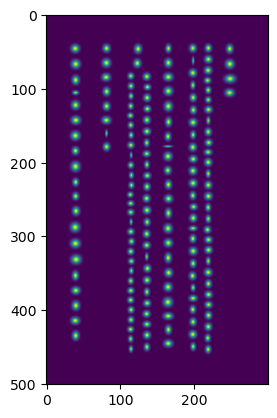

Epoch 1/100 [Train]:   0%|          | 7/4965 [00:44<2:30:33,  1.82s/it, loss=0.0117]

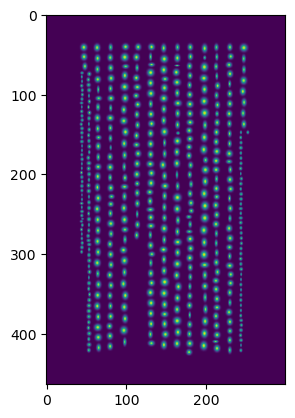

Epoch 1/100 [Train]:   0%|          | 8/4965 [00:44<1:46:07,  1.28s/it, loss=0.0135]

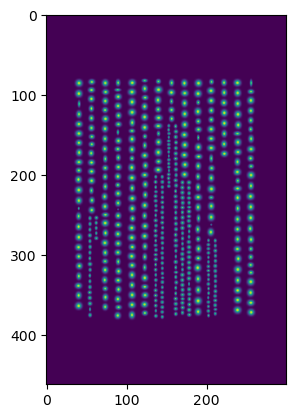

Epoch 1/100 [Train]:   0%|          | 9/4965 [00:44<1:17:52,  1.06it/s, loss=0.0109]

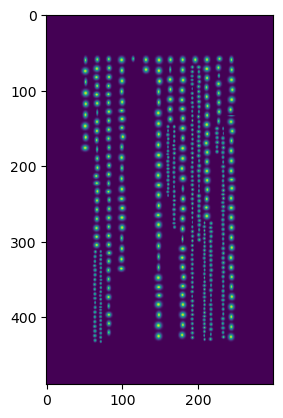

Epoch 1/100 [Train]:   0%|          | 10/4965 [00:48<2:20:57,  1.71s/it, loss=0.0101]

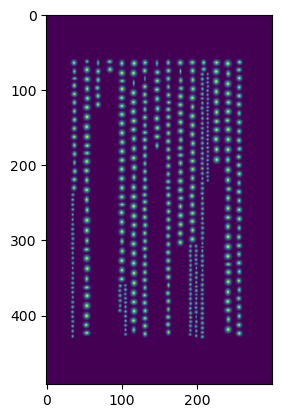

Epoch 1/100 [Train]:   0%|          | 11/4965 [00:48<1:40:21,  1.22s/it, loss=0.0124]

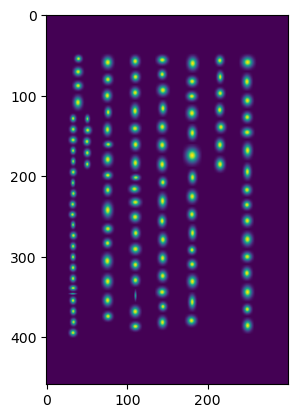

Epoch 1/100 [Train]:   0%|          | 12/4965 [00:48<1:12:48,  1.13it/s, loss=0.0119]

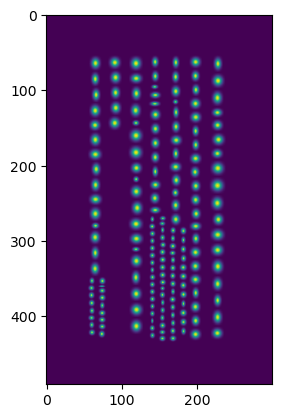

Epoch 1/100 [Train]:   0%|          | 13/4965 [00:48<53:21,  1.55it/s, loss=0.0103]  

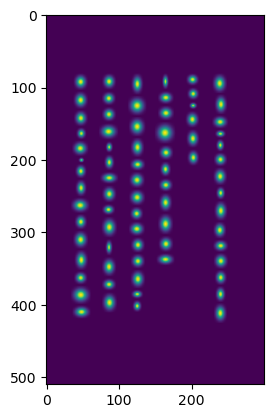

Epoch 1/100 [Train]:   0%|          | 14/4965 [00:48<40:24,  2.04it/s, loss=0.0108]

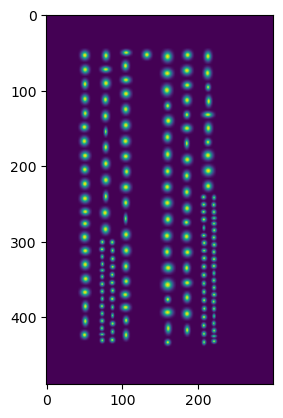

Epoch 1/100 [Train]:   0%|          | 15/4965 [00:48<30:53,  2.67it/s, loss=0.0101]

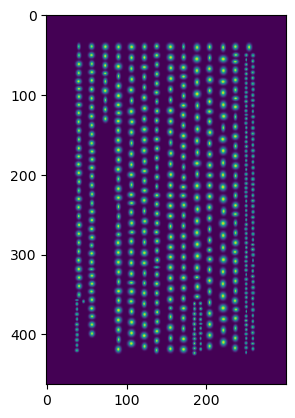

Epoch 1/100 [Train]:   0%|          | 16/4965 [00:48<24:23,  3.38it/s, loss=0.0141]

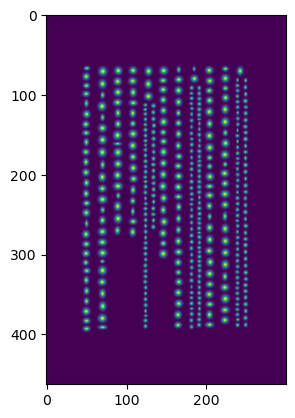

Epoch 1/100 [Train]:   0%|          | 17/4965 [00:48<20:09,  4.09it/s, loss=0.0128]

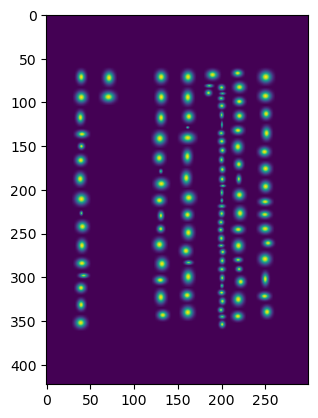

Epoch 1/100 [Train]:   0%|          | 18/4965 [00:49<17:48,  4.63it/s, loss=0.0106]

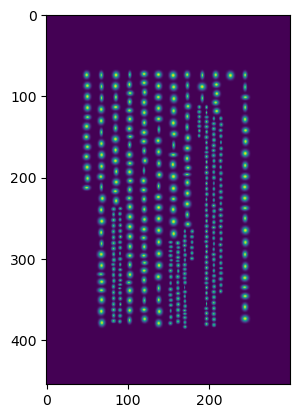

Epoch 1/100 [Train]:   0%|          | 19/4965 [00:49<15:29,  5.32it/s, loss=0.00903]

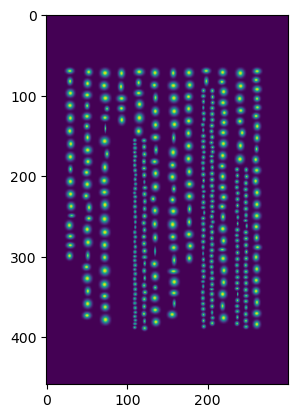

Epoch 1/100 [Train]:   0%|          | 20/4965 [00:50<43:02,  1.91it/s, loss=0.0138] 

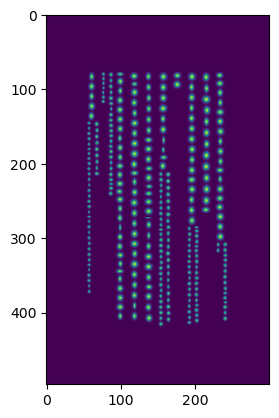

Epoch 1/100 [Train]:   0%|          | 21/4965 [00:50<3:18:41,  2.41s/it, loss=0.00867]


KeyboardInterrupt: 

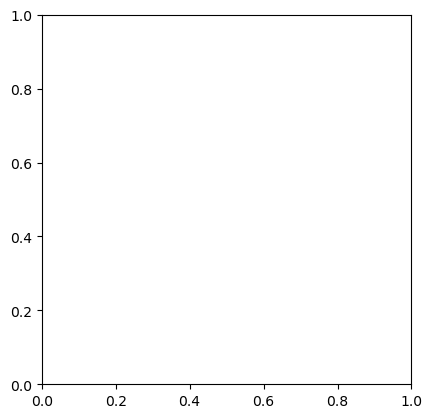

In [2]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
from src.my_app import UNet, create_optimized_dataloader
from src.my_app.core.MyDataset.OldMyDataset import PreTrainDataset_old
import torch
from PIL import Image
import torchvision.transforms as transforms
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
import json
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing as mp


def crop_labels_to_match(labels_to_crop, target_tensor):
    target_h, target_w = target_tensor.shape[2:]
    source_h, source_w = labels_to_crop.shape[2:]
    delta_h = (source_h - target_h) // 2
    delta_w = (source_w - target_w) // 2
    return labels_to_crop[:, :, delta_h:delta_h + target_h, delta_w:delta_w + target_w]
transform = transforms.Compose([
    # transforms.Resizeze((128, 128)),
    transforms.ToTensor()
])
# --- Dataset ---
test_doc_id_list = ['100241706', '100249371', '100249376', '100249416', '100249476', '100249537', '200003076', '200003803', '200003967', '200004107']


train_dataset = dataset = PreTrainDataset_old(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=False,
    # device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # precompute_gt=False,
    transform=transform,
    # target_width=400  # 横幅を400ピクセルに固定
)

test_dataset = PreTrainDataset_old(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=True,
    # device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # precompute_gt=False,
    transform=transform,
    # target_width=400  # 横幅を400ピクセルに固定
)


# 最適化されたDataLoaderの作成
train_dl = PreTrainDataset_old.create_optimized_dataloader_for_old_dataset(
    train_dataset,
    batch_size=1,
    num_workers=min(mp.cpu_count(), 4)
)
test_dl = PreTrainDataset_old.create_optimized_dataloader_for_old_dataset(
    test_dataset,
    batch_size=1,
    num_workers=min(mp.cpu_count(), 4)
)
# train_dl = create_optimized_dataloader(train_dataset, batch_size=1, num_workers=min(mp.cpu_count(), 4))
# test_dl = create_optimized_dataloader(test_dataset, batch_size=1, num_workers=min(mp.cpu_count(), 4))

# --- モデル、損失関数、最適化手法の定義 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = UNet(3, 4).to(device)
criterion = nn.MSELoss() # 回帰問題なのでMSE損失を使用
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- チェックポイントの設定 ---
checkpoint_dir = "../.checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# 最良のモデルを追跡するための変数
best_test_loss = float('inf')
start_epoch = 0

# チェックポイントの読み込み（存在する場合）
checkpoint_path = os.path.join(checkpoint_dir, "latest_checkpoint.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_test_loss = checkpoint['best_test_loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    print(f"チェックポイントを読み込みました（エポック {start_epoch}）")

num_epochs = 100 # エポック数を定義

# 損失の履歴を保存するリストを初期化
train_loss_history = []
test_loss_history = []

print("学習を開始します...")
for epoch in range(start_epoch, num_epochs):
    print(f'start epcoch')
    # --- 訓練フェーズ ---
    model.train() # モデルを訓練モードに設定
    train_loss_total = 0
    
    # tqdmでプログレスバーを表示
    train_bar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for imgs, masks in train_bar:
        imgs, masks = imgs.to(device), masks.to(device)
        
        preds = model(imgs)
        cropped_masks = crop_labels_to_match(masks, preds)

        loss = criterion(preds, cropped_masks)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_total += loss.item()
        # プログレスバーに現在のロスを表示
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = train_loss_total / len(train_dl)
    train_loss_history.append(avg_train_loss)

    # --- 評価フェーズ ---
    model.eval() # モデルを評価モードに設定
    test_loss_total = 0
    
    # 勾配計算を無効化して、メモリ効率を良くする
    with torch.no_grad():
        test_bar = tqdm(test_dl, desc=f"Epoch {epoch+1}/{num_epochs} [Test]")
        for imgs, masks in test_bar:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            cropped_masks = crop_labels_to_match(masks, preds)
            
            loss = criterion(preds, cropped_masks)
            test_loss_total += loss.item()
            test_bar.set_postfix(loss=loss.item())

    avg_test_loss = test_loss_total / len(test_dl)
    test_loss_history.append(avg_test_loss)
    
    # 各エポックの最後に訓練ロスとテストロスを表示
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")
    
    # 最新のチェックポイントを保存
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss_history': train_loss_history,
        'test_loss_history': test_loss_history,
        'best_test_loss': best_test_loss
    }, os.path.join(checkpoint_dir, "latest_checkpoint.pth"))
    
    # より良い性能が出た場合、ベストモデルとして保存
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': avg_test_loss,
        }, os.path.join(checkpoint_dir, "best_model.pth"))
        print(f"新しいベストモデルを保存しました（Test Loss: {avg_test_loss:.4f}）")

print("学習が完了しました。")

# --- 損失の推移をグラフで表示 ---
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train Loss")
plt.plot(test_loss_history, label="Test Loss")
plt.title("Loss Trend")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()